# Анализ тональности текста

Мы обучим модель для классификации текстов на *положительные* и *отрицательные* отзывы, используя предобученные *векторы слов*.

In [1]:
import re
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from collections import Counter


## Embeddings

Будем использовать эмбеддинги 3-ех миллионов слов, размерностью 300, обученные на 3 миллиардах слов из *Google News corpus (circa 2015)*.

In [2]:
!gdown -c "https://drive.google.com/uc?id=17Vf3ucDBnHMarELN_yYaRu0lHXdulGTZ"

Skipping already downloaded file GoogleNews-vectors-negative300.bin.gz


In [3]:
embedding_file = "./GoogleNews-vectors-negative300.bin.gz"

In [4]:
word_vectors = KeyedVectors.load_word2vec_format(
    embedding_file, binary=True, limit=1_000_000
)

## Датасет

**Yelp Polarity Reviews** - датасет из ~600 000 отзывов.

Оригинальные отзывы имеют оценку от *1 до 5* звезд. Но мы будем использовать только бинарную оценку *(negative if label==1 and positive if label==2).

In [5]:
!wget -c "https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz"

--2025-10-15 18:42:25--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.166.40, 16.182.36.192, 52.217.9.158, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.166.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [6]:
# !tar xvzf yelp_review_polarity_csv.tgz

In [7]:
yelp_train = pd.read_csv(
    "yelp_review_polarity_csv/train.csv", names=["sentiment", "review"]
)

In [8]:
yelp_train.head()

,sentiment,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


Для ускорения обучения возьмем только 100 000 отзывов, предварительно перемещав их, на всякий случай, если исходный датасет каким-либо образом отсортирован

In [9]:
TRAIN_SIZE = 100000
yelp_train = yelp_train.sample(n=TRAIN_SIZE, random_state=1, ignore_index=True)
print(yelp_train.shape)

(100000, 2)


У нас задача бинарной классификации, поэтому переведем метки в значения 0 и 1 (вместо 1 и 2).

In [10]:
yelp_train.replace(to_replace={"sentiment": {1: 0, 2: 1}}, inplace=True)

In [11]:
yelp_train.head()

,sentiment,review
0,1,"omg, the grandma g's pizza with rosemary chick..."
1,0,Microwaved food over over over seasoned gyro m...
2,0,"While the food is good, the service leaves a l..."
3,0,Called the Chandler PD about the sign spinner ...
4,1,"Just took Ewok, my approx. 6 month old shih tz..."


## Train-validation split

In [12]:
train_reviews, val_reviews, y_train, y_val = train_test_split(
    yelp_train["review"],
    yelp_train["sentiment"],
    train_size=0.85,
    random_state=1,
)

Посмотрим, сбалансированы ли классы в тренировочной выборке

In [13]:
Counter(y_train)

Counter({1: 42605, 0: 42395})

## Токенизация

- Оставляем только слова;
- Отбираем топ 20 000 самых частых слов.

Отбор топ-20 000 — это способ отсечь шумные и слишком редкие слова, уменьшить размерность и ускорить обучение. В большинстве датасетов отзывов 20 000 слов хватает, чтобы покрыть подавляющее большинство текста (частотное распределение слов следует закону Ципфа: относительно мало слов встречаются очень часто).

Создадим класс, унаследованный от `sklearn.feature_extraction.text. CountVectorizer`, для отбора *топ 20 000* слов. Дополним словарями для получения *индексов по словам* и *слов по индексам*

In [14]:
class Tokenizer(CountVectorizer):
    def __init__(
        self,
        *,
        lowercase=False,
        tokenizer=None,
        token_pattern=None,
        max_features=None,
    ):
        super().__init__(
            tokenizer=tokenizer,
            token_pattern=token_pattern,
            lowercase=lowercase,
            max_features=max_features,
        )

    def fit(self, raw_documents, y=None):
        super().fit(raw_documents)
        # sklearn хранит словарь слово -> id
        sorted_vocab = sorted(self.vocabulary_.items(), key=lambda x: x[1])
        # начинаем индексацию с 1
        self.word_index = {
            word: idx + 1 for idx, (word, _) in enumerate(sorted_vocab)
        }
        self.index_word = {idx: word for word, idx in self.word_index.items()}
        return self

    def texts_to_sequences(self, texts: list[str]) -> list[list[int]]:
        sequences = []
        for text in texts:
            tokens = self.tokenizer(text)
            seq = []
            for tok in tokens:
                idx = self.word_index.get(tok)
                if idx is not None:
                    seq.append(idx)
            sequences.append(seq)
        return sequences

    def sequences_to_texts(self, sequences: list[list[int]]) -> list[str]:
        texts = []
        for seq in sequences:
            tokens = [self.index_word.get(i, "") for i in seq]
            texts.append(" ".join(tokens))
        return texts


def simple_tokenizer(text):
    # удаляем цифры и пунктуацию, оставляем только буквы
    text = re.sub(r"[^a-zA-Zа-яА-ЯёЁ]", " ", text)
    text = text.lower()
    tokens = text.split()
    return tokens


tokenizer = Tokenizer(
    tokenizer=simple_tokenizer,
    lowercase=False,
    max_features=20000,
    token_pattern=None,
)

In [15]:
tokenizer.fit(train_reviews.values)

,lowercase,False
,tokenizer,<function sim...x77cf2681cd60>
,token_pattern,None
,max_features,20000


Получение индексов слов

In [16]:
X_train = tokenizer.texts_to_sequences(train_reviews)

In [17]:
print(X_train[0])

[6869, 11036, 8161, 6284, 6711, 11047, 12217, 17951, 19374, 569, 18802, 6018, 18122, 15464, 17889, 9550, 17889, 19766, 12855, 12337, 8865, 430, 19374, 17889, 19419, 5198, 7769, 18397, 10367, 5061, 12415, 13798, 15927, 8778, 17904, 4915, 17897, 13389, 579, 15293, 7303, 1453, 9555, 17889, 8161, 8210, 8321, 4751, 11837, 10419, 5198, 7769, 12489, 6404, 12566, 19516, 7924, 13389, 6676, 11036, 2625, 19504, 18843, 8321, 908, 18122, 15675, 7924, 19538, 8848, 19530, 10862, 18460, 1456, 12417, 12337, 17889, 11591, 12160, 7639, 13483, 12566, 166, 12415, 17889, 1159, 15265, 7851, 14306, 10807, 17885, 15893, 6739, 19761, 579, 7068, 1, 1336, 6039, 18122, 11036, 8292, 19565, 19374, 8459, 17889, 15131, 12416, 10036, 1123, 12337, 17951, 11036, 8292, 579, 8321, 908, 1, 6325, 6955, 14155, 2323, 17033, 4753, 17545, 14177, 18688, 17889, 16191, 8877, 13615, 12489, 5856, 1328, 12415, 17889, 12158, 15265, 642, 19428, 19504, 17033, 384, 579, 16452, 908, 8361, 19428, 3885, 16656, 19681, 17889, 5059, 26, 17889, 

In [18]:
[tokenizer.index_word[x] for x in X_train[0][:3]]

['from', 'my', 'hospital']

Получение текста по индексам

In [19]:
print("Текст, полученный по индексам:")
print(tokenizer.sequences_to_texts([X_train[0]])[0][:300])
print()
print("Оригинальный текст:")
print(train_reviews.iloc[0][:300])

Текст, полученный по индексам:
from my hospital feedback form n nwhile this was an unpleasant experience to say the least the worst part of it all was the way dr haslett treated me doctors on previous shifts introduced themselves discussed their plans and said goodbye before leaving the hospital however i did not meet dr haslett 

Оригинальный текст:
From my hospital feedback form:\n\nWhile this was an unpleasant experience to say the least, the worst part of it all was the way Dr. Haslett treated me.  Doctors on previous shifts introduced themselves, discussed their plans and said goodbye before leaving the hospital.  However, I did not meet Dr


## Приведение последовательностей к одной длине. Преобразование в tensor

Часто чтобы обучить модель необходимо, чтобы последовательности были одной длины.

Мы ограничим последовательности *200* токенами. Если токенов больше, последовательность обрезается, если меньше - дополняется нулями (в начале).

In [20]:
# У нас есть -> перевести в
#
# X_train: list[list[int]] -> tensor torch.long
# val_reviews: list[list[str]] -> list[list[int]] -> tensor dtype long
# y_train: Series[int] -> tensor torch.float32
# y_val: Series[int] -> tensor torch.float32

# Последовательности
X_train
X_val = tokenizer.texts_to_sequences(val_reviews)


In [21]:
def pad_sequence(
    sequences: list[list[int]], max_len: int, value=0
) -> torch.Tensor:
    padded = torch.full((len(sequences), max_len), fill_value=0)

    for i, seq in enumerate(sequences):
        trunc = torch.tensor(seq[: min(len(seq), max_len)], dtype=torch.long)
        padded[i, : len(trunc)] = trunc

    return padded

In [22]:
# Приведение к одному размеру и в тип tensor
MAX_REVIEW_LEN = 200

X_train_padded = pad_sequence(X_train, MAX_REVIEW_LEN)
X_val_padded = pad_sequence(X_val, MAX_REVIEW_LEN)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

## Создание матрицы весов для Embedding слоя

Возьмем векторы из `gensim` (`word_vectors`) для слов из нашего словаря (`tokenizer.word_index`)

In [23]:
word_vectors["good"].dtype

dtype('float32')

In [24]:
# +1 для индекса 0
# (если мы, допустим, дополнили последовательность 0-ями до размера 200)
num_embeddings = len(tokenizer.word_index) + 1
embedding_dim = 300

embedding_matrix = torch.zeros(
    (num_embeddings, embedding_dim), dtype=torch.float32
)

for word, i in tokenizer.word_index.items():
    if word_vectors.has_index_for(word):
        embedding_matrix[i] = torch.tensor(
            word_vectors[word], dtype=torch.float32
        )


In [25]:
# Проверка
print(embedding_matrix[tokenizer.word_index["good"]][:50])

tensor([ 0.0405,  0.0625, -0.0175,  0.0786,  0.0327, -0.0126,  0.0096,  0.1235,
        -0.0215,  0.1523, -0.0583, -0.1064,  0.0212,  0.1357, -0.1318,  0.1768,
         0.2715,  0.1377, -0.1738, -0.1416, -0.0308,  0.1963, -0.0330,  0.1250,
         0.2539,  0.1270, -0.1523,  0.0320,  0.0114, -0.0136, -0.1289,  0.0102,
         0.2393, -0.0845,  0.1406,  0.1309, -0.0452,  0.0649,  0.0254,  0.0562,
         0.2461, -0.2051,  0.2363, -0.0086, -0.0229,  0.0508,  0.1064, -0.0356,
         0.0874, -0.0571])


## Обучение модели

In [26]:
class SequenceMeanPooling(nn.Module):
    """Слой для усреднения по последовательности (по оси seq_length)"""

    def forward(self, x):
        # x: (batch_size, seq_length, features)
        return torch.mean(x, dim=1, keepdim=False)


class SentimentClassifier(nn.Module):
    def __init__(self, embeddings: torch.Tensor):
        """
        Args:
            embeddings (torch.Tensor): shape=(num_embeddings, embedding_dim). Первым элементом должен быть вектор из 0-ей (для 0-ых индексов последовательности)
        """
        super().__init__()

        # Embedding слой. Инициализация весов
        self.num_embeddings, self.embedding_dim = embeddings.shape

        self.embedding = nn.Embedding(
            self.num_embeddings, self.embedding_dim, padding_idx=0
        )
        self.embedding.weight.data.copy_(embeddings)

        # Усреднение векторов последовательности
        self.avg_pooling = SequenceMeanPooling()

        self.fc1 = nn.Sequential(
            nn.Linear(self.embedding_dim, 128), nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(inplace=True))
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        # X: (batch_size, seq_length, features)
        x = self.embedding(x)
        x = self.avg_pooling(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)

        return x


class ClassifierDataset(data.Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        super().__init__()
        self.X = X
        self.y = y
        self.length = self.X.size(0)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.length


In [27]:
class ClassifierTrainer:
    def __init__(
        self,
        model: nn.Module,
        criterion: nn.Module,
        optimizer: optim.Optimizer,
        train_dataloader: data.DataLoader,
        val_dataloader: data.DataLoader,
        epochs: int,
        patience: int,
        device: torch.device,
    ):
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.patience = patience
        self.device = device

    def compute_metrics(self, y_pred, y_true):
        return {"accuracy": accuracy_score(y_true, y_pred)}

    def _train_epoch(self):
        self.model.train()

        epoch_loss = 0
        epoch_probas = []
        epoch_labels = []
        for X, y in tqdm(self.train_dataloader, desc="Training"):
            X, y = X.to(self.device), y.to(self.device)
            outputs = self.model(X).squeeze()
            loss = self.criterion(outputs, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
            epoch_probas.extend(torch.sigmoid(outputs.detach().cpu()).numpy())
            epoch_labels.extend(y.detach().cpu().numpy())

        epoch_loss /= len(self.train_dataloader)
        epoch_predicts = (np.array(epoch_probas) > 0.5).astype(int)
        metrics = self.compute_metrics(epoch_predicts, epoch_labels)
        return epoch_loss, metrics

    def _validate(
        self, dataloader=None
    ) -> tuple[float, dict[str, float | int]]:
        if dataloader is None:
            dataloader = self.val_dataloader
        self.model.eval()
        epoch_loss = 0
        epoch_probas = []
        epoch_labels = []
        with torch.no_grad():
            for X, y in tqdm(dataloader, desc="Validation"):
                X, y = X.to(self.device), y.to(self.device)

                outputs = self.model(X).squeeze()
                loss = self.criterion(outputs, y)

                epoch_loss += loss.item()
                epoch_probas.extend(
                    torch.sigmoid(outputs.detach().cpu()).numpy()
                )
                epoch_labels.extend(y.detach().cpu().numpy())

        epoch_loss /= len(dataloader)
        epoch_predicts = (np.array(epoch_probas) > 0.5).astype(int)
        metrics = self.compute_metrics(
            epoch_predicts,
            epoch_labels,
        )
        return epoch_loss, metrics

    def test(
        self, test_dataloader: data.DataLoader
    ) -> tuple[float, dict[str, float | int]]:
        return self._validate(test_dataloader)

    def __append_to_history(self, **kwargs):
        for k in self.history:
            self.history[k].append(kwargs[k])

    def train(self):
        self.history = dict(
            train_loss=[], val_loss=[], train_accuracy=[], val_accuracy=[]
        )
        best_score = 0
        no_improve = 0
        best_model = self.model.state_dict()
        for epoch in range(self.epochs):
            train_loss, train_metrics = self._train_epoch()
            val_loss, val_metrics = self._validate()
            self.__append_to_history(
                train_loss=train_loss,
                train_accuracy=train_metrics["accuracy"],
                val_loss=val_loss,
                val_accuracy=val_metrics["accuracy"],
            )

            print(f"Epoch {epoch + 1}/{self.epochs}")
            print(
                f"Train Loss:      {train_loss:.3f}, "
                f"Train Accuracy:      {train_metrics['accuracy']:.3f}"
            )
            print(
                f"Validation Loss: {val_loss:.3f}, "
                f"Validation Accuracy: {val_metrics['accuracy']:.3f}"
            )
            print()
            if best_score < val_metrics["accuracy"]:
                best_score = val_metrics["accuracy"]
                best_model = self.model.state_dict()
                no_improve = 0
            else:
                no_improve += 1
            if no_improve > self.patience:
                print(f"Early stopping after {epoch + 1} epoch")
                self.model.load_state_dict(best_model)
                break

        print(f"Best Accuracy: {best_score:.4f}")
        return self.history

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
epochs = 20
patience = 3
batch_size = 512

train_dataset = ClassifierDataset(X_train_padded, y_train)
val_dataset = ClassifierDataset(X_val_padded, y_val)

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

model = SentimentClassifier(embedding_matrix)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trainer = ClassifierTrainer(
    model,
    criterion,
    optimizer,
    train_dataloader,
    val_dataloader,
    epochs=epochs,
    patience=patience,
    device=device,
)
history = trainer.train()

Device: cuda


Validation: 100%|██████████| 30/30 [00:00<00:00, 585.54it/s]


Epoch 1/20
Train Loss:      0.416, Train Accuracy:      0.814
Validation Loss: 0.247, Validation Accuracy: 0.912



Validation: 100%|██████████| 30/30 [00:00<00:00, 543.77it/s]


Epoch 2/20
Train Loss:      0.205, Train Accuracy:      0.926
Validation Loss: 0.233, Validation Accuracy: 0.915



Validation: 100%|██████████| 30/30 [00:00<00:00, 548.07it/s]


Epoch 3/20
Train Loss:      0.177, Train Accuracy:      0.939
Validation Loss: 0.241, Validation Accuracy: 0.913



Validation: 100%|██████████| 30/30 [00:00<00:00, 567.99it/s]


Epoch 4/20
Train Loss:      0.157, Train Accuracy:      0.946
Validation Loss: 0.253, Validation Accuracy: 0.913



Validation: 100%|██████████| 30/30 [00:00<00:00, 575.08it/s]


Epoch 5/20
Train Loss:      0.140, Train Accuracy:      0.950
Validation Loss: 0.260, Validation Accuracy: 0.912



Validation: 100%|██████████| 30/30 [00:00<00:00, 581.40it/s]

Epoch 6/20
Train Loss:      0.129, Train Accuracy:      0.956
Validation Loss: 0.289, Validation Accuracy: 0.907

Early stopping after 6 epoch
Best Accuracy: 0.9146


## Оценка качества модели

In [29]:
def plot_history(history: dict[list]):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))

    ax1.plot(history["train_loss"], label="Train Loss", color="blue")
    ax1.plot(history["val_loss"], label="Validation Loss", color="red")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_title("Training and Validation Loss")
    ax1.legend()
    ax1.grid()

    ax2.plot(history["train_accuracy"], label="Train Accuracy", color="blue")
    ax2.plot(history["val_accuracy"], label="Validation Accuracy", color="red")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Training and Validation Accuracy")
    ax2.legend()
    ax2.grid()

    fig.suptitle("Model Training Metrics", fontsize=16)

    fig.tight_layout(pad=2)
    plt.show()

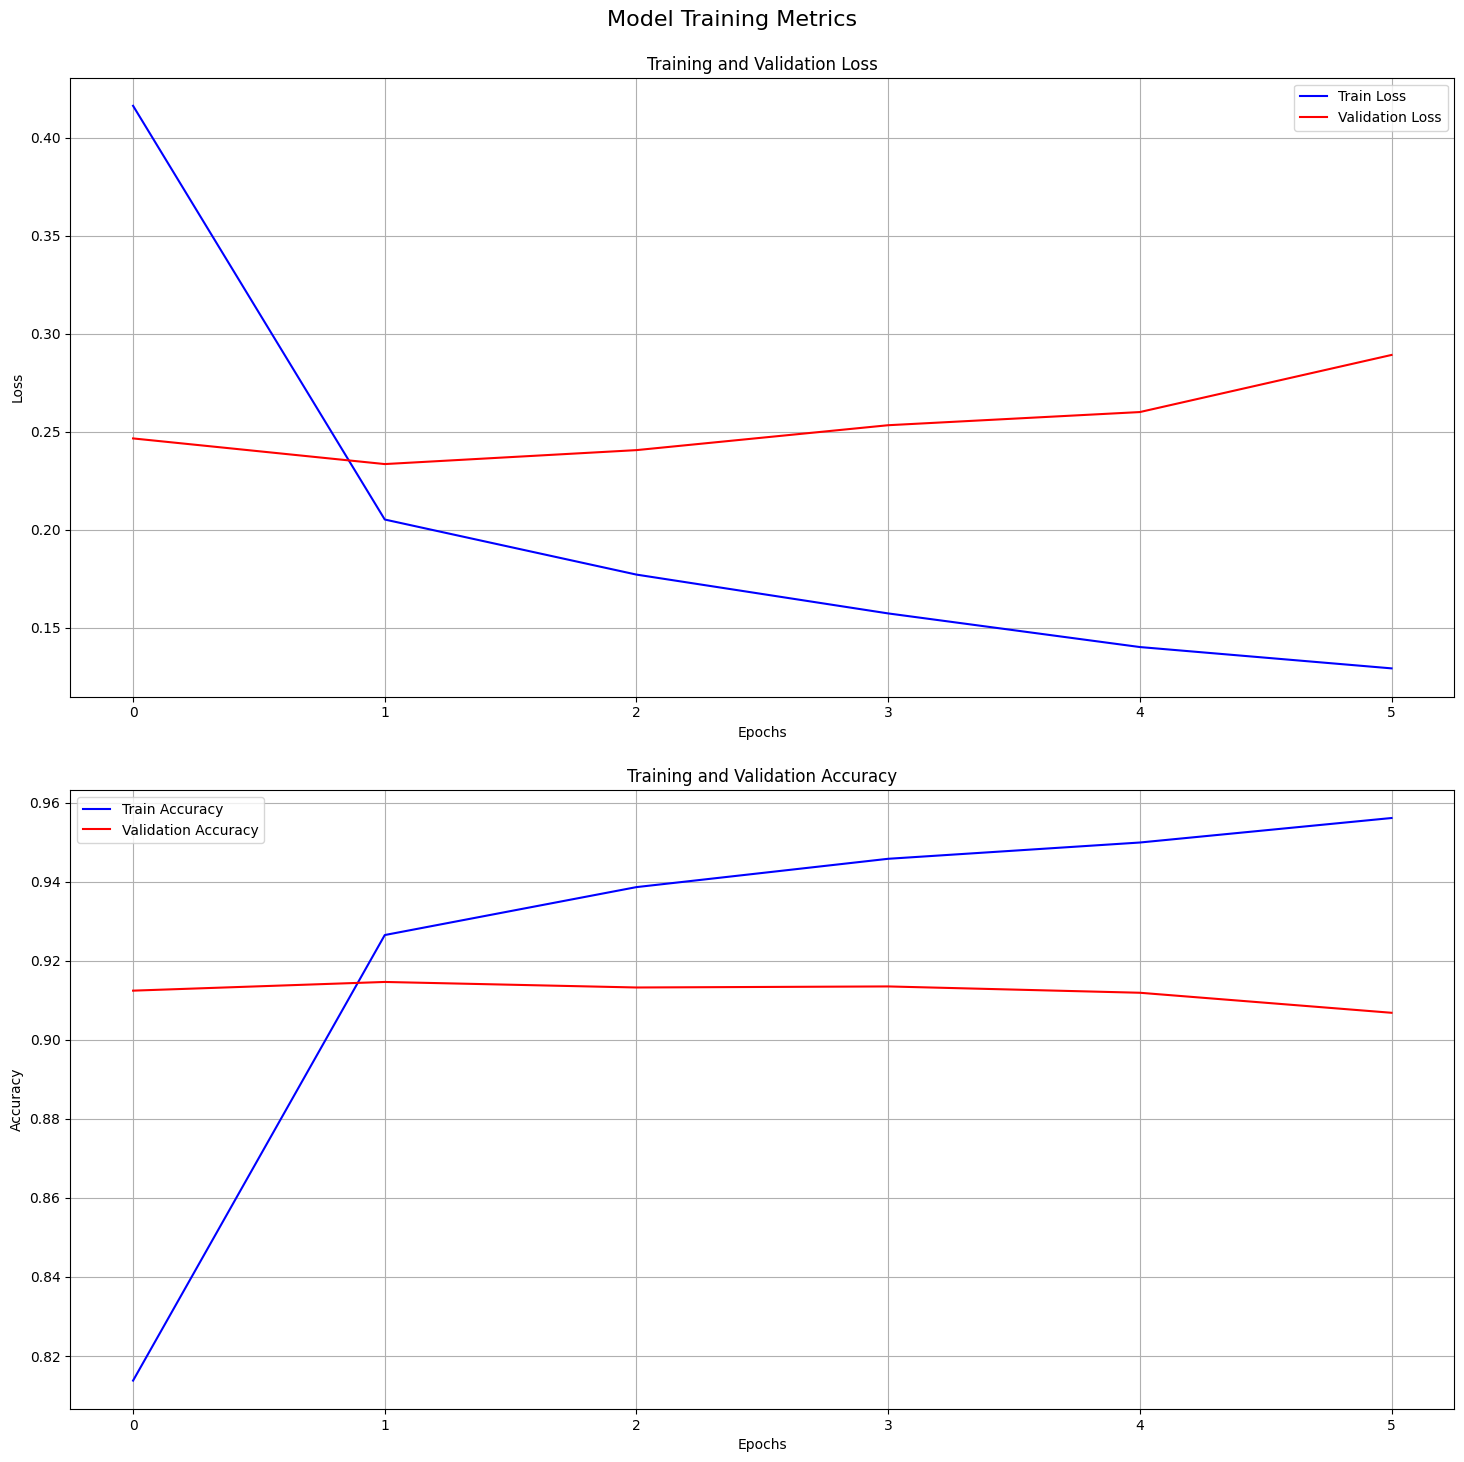

In [30]:
plot_history(history)

## Тестирование модели

In [31]:
yelp_test = pd.read_csv(
    "yelp_review_polarity_csv/test.csv", names=["sentiment", "review"]
)

In [32]:
yelp_test.replace(to_replace={"sentiment": {1: 0, 2: 1}}, inplace=True)
yelp_test.head()

,sentiment,review
0,1,"Contrary to other reviews, I have zero complai..."
1,0,Last summer I had an appointment to get new ti...
2,1,"Friendly staff, same starbucks fair you get an..."
3,0,The food is good. Unfortunately the service is...
4,1,Even when we didn't have a car Filene's Baseme...


In [33]:
X_test = tokenizer.texts_to_sequences(yelp_test["review"])

In [34]:
X_test_padded = pad_sequence(X_test, MAX_REVIEW_LEN)

In [35]:
y_test = torch.tensor(yelp_test["sentiment"].values, dtype=torch.float32)

In [36]:
test_dataset = ClassifierDataset(X_test_padded, y_test)
test_dataloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)
loss, metrics = trainer.test(test_dataloader)

Validation: 100%|██████████| 75/75 [00:00<00:00, 407.65it/s]


In [37]:
print(f"Test Loss:     {loss:.3f}")
print(f"Test Accuracy: {metrics['accuracy']:.3f}")

Test Loss:     0.265
Test Accuracy: 0.916


Неплохой результат

## Инференс

Теперь модель можно использовать для прогнозов

In [38]:
def predict(reviews: str | list[str]) -> str:
    if isinstance(reviews, str):
        reviews = [reviews]
    seqs = tokenizer.texts_to_sequences(reviews)
    seqs = pad_sequence(seqs, MAX_REVIEW_LEN).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(seqs).detach().cpu().squeeze()
    probs = torch.sigmoid(outputs).numpy()
    predicts = probs > 0.5
    return ["Positive" if pred else "Negative" for pred in predicts]

In [39]:
# Real reviews from Google Reviews.
pos_review = "The best seafood joint in East Village San Diego!  Great lobster roll, great fish, great oysters, great bread, great cocktails, and such amazing service.  The atmosphere is top notch and the location is so much fun being located just a block away from Petco Park (San Diego Padres Stadium)."
neg_review = "A thoroughly disappointing experience. When you book a Marriott you expect a certain standard. Albany falls way short. Room cleaning has to be booked 24 hours in advance but nobody thought to mention this at check in. The hotel is tired and needs a face-lift. The only bright light in a sea of mediocrity were the pancakes at breakfast. Sadly they weren't enough to save the experience. If you travel to Albany, then do yourself a big favour and book the Westin."

In [40]:
print(predict([pos_review, neg_review]))

['Positive', 'Negative']


## Что будет, если использовать необученные веса

Чтобы не переписывать код, запишу так

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
epochs = 20
patience = 3
batch_size = 512

train_dataset = ClassifierDataset(X_train_padded, y_train)
val_dataset = ClassifierDataset(X_val_padded, y_val)

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

model = SentimentClassifier(embedding_matrix)
model.embedding = nn.Embedding(
    num_embeddings=embedding_matrix.shape[0],
    embedding_dim=embedding_matrix.shape[1],
    padding_idx=0,
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trainer = ClassifierTrainer(
    model,
    criterion,
    optimizer,
    train_dataloader,
    val_dataloader,
    epochs=epochs,
    patience=patience,
    device=device,
)
history = trainer.train()

Device: cuda


Validation: 100%|██████████| 30/30 [00:00<00:00, 483.60it/s]


Epoch 1/20
Train Loss:      0.442, Train Accuracy:      0.796
Validation Loss: 0.301, Validation Accuracy: 0.885



Validation: 100%|██████████| 30/30 [00:00<00:00, 459.11it/s]


Epoch 2/20
Train Loss:      0.253, Train Accuracy:      0.903
Validation Loss: 0.251, Validation Accuracy: 0.904



Validation: 100%|██████████| 30/30 [00:00<00:00, 488.39it/s]


Epoch 3/20
Train Loss:      0.200, Train Accuracy:      0.923
Validation Loss: 0.237, Validation Accuracy: 0.906



Validation: 100%|██████████| 30/30 [00:00<00:00, 498.31it/s]


Epoch 4/20
Train Loss:      0.174, Train Accuracy:      0.933
Validation Loss: 0.241, Validation Accuracy: 0.908



Validation: 100%|██████████| 30/30 [00:00<00:00, 490.62it/s]


Epoch 5/20
Train Loss:      0.158, Train Accuracy:      0.939
Validation Loss: 0.230, Validation Accuracy: 0.913



Validation: 100%|██████████| 30/30 [00:00<00:00, 481.80it/s]


Epoch 6/20
Train Loss:      0.146, Train Accuracy:      0.945
Validation Loss: 0.228, Validation Accuracy: 0.913



Validation: 100%|██████████| 30/30 [00:00<00:00, 486.97it/s]


Epoch 7/20
Train Loss:      0.130, Train Accuracy:      0.952
Validation Loss: 0.236, Validation Accuracy: 0.913



Validation: 100%|██████████| 30/30 [00:00<00:00, 497.90it/s]


Epoch 8/20
Train Loss:      0.119, Train Accuracy:      0.956
Validation Loss: 0.251, Validation Accuracy: 0.912



Validation: 100%|██████████| 30/30 [00:00<00:00, 461.88it/s]

Epoch 9/20
Train Loss:      0.112, Train Accuracy:      0.959
Validation Loss: 0.262, Validation Accuracy: 0.910

Early stopping after 9 epoch
Best Accuracy: 0.9133


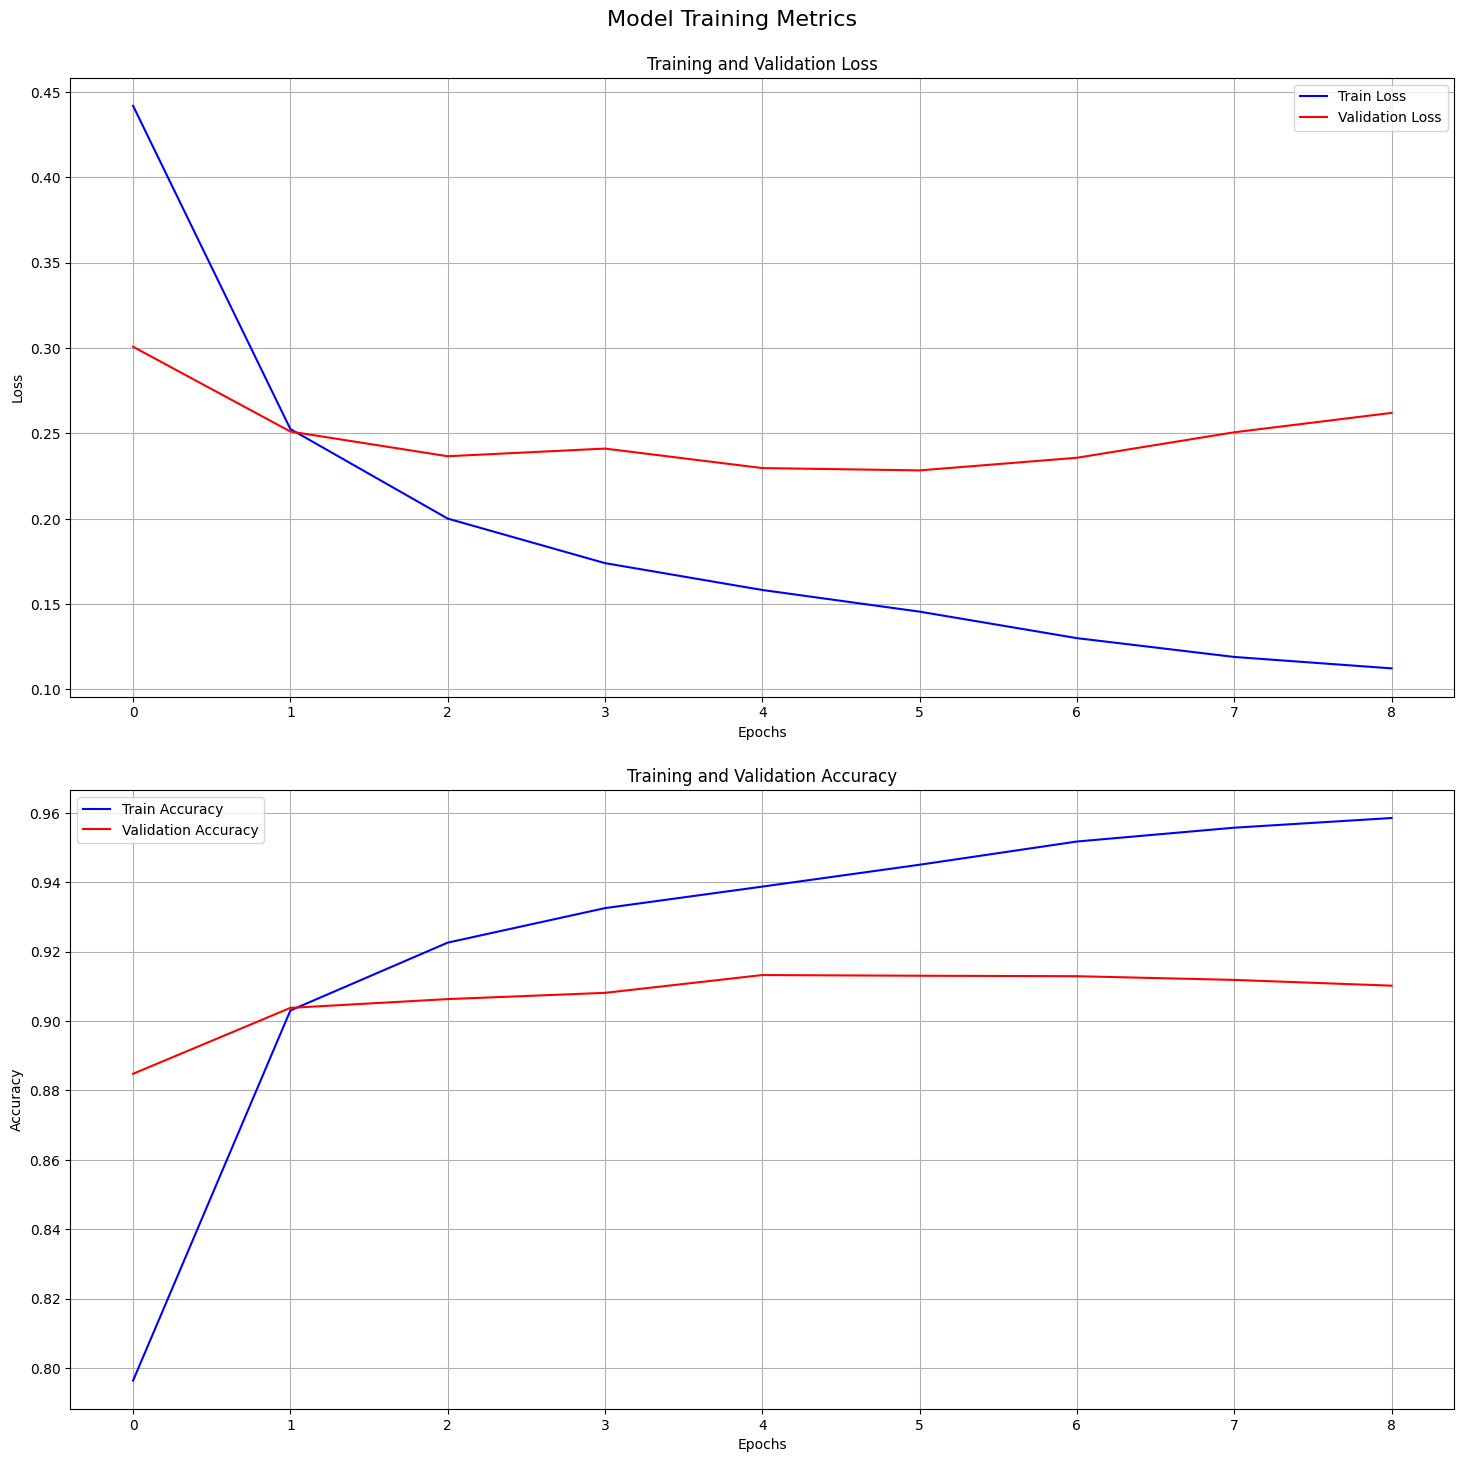

In [42]:
plot_history(history)

In [43]:
loss, metrics = trainer.test(test_dataloader)

Validation: 100%|██████████| 75/75 [00:00<00:00, 397.90it/s]


In [44]:
print(f"Test Loss:     {loss:.3f}")
print(f"Test Accuracy: {metrics['accuracy']:.3f}")

Test Loss:     0.244
Test Accuracy: 0.916


Качество сопоставима с моделью, в котором мы использовали предобученные веса. Вероятно, так произошло из-за характера данных и их объема.